## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
import math
import glob
from pyliftover import LiftOver
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [8]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
gene_annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
aut_variants_file_path = data_path + 'aut.tsv.gz'
constraint_predictions_file_path = results_path + f'HMM_rgc_0.9_over20_chr2_predictions_rgc_wes.tsv.gz'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'

## Define helper methods

In [3]:
def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

def calculate_effect_size_and_variance(cases_df):
    ALT_AJ = cases_df['ac_case']
    ALT_ExAC = cases_df['ac_ctrl']
    REF_AJ = cases_df['an_case'] - cases_df['ac_case']
    REF_ExAC = cases_df['an_ctrl'] - cases_df['ac_ctrl']

    cases_df['effect_size'] = np.log(((0.5 + ALT_AJ) * (0.5 + REF_ExAC)) / ((0.5 + REF_AJ) * (0.5 + ALT_ExAC)))
    cases_df['var_effect_size'] = (1 / (0.5 + REF_AJ) + 1 / (0.5 + REF_ExAC) + 1 / (0.5 + ALT_AJ) + 1 / (0.5 + ALT_ExAC))
    
    return cases_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - stats.chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Load data

In [4]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(gene_annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [5]:
# Read the data into a DataFrame
aut_df = pd.read_csv(aut_variants_file_path, sep='\t')

# Reset the index before assigning values
aut_df[['chr', 'pos','ref','alt']] = aut_df['v'].str.split(':', expand=True)

# Convert 'chr' and 'pos' columns to integers
aut_df['chr'] = 'chr' + aut_df['chr'].astype(str)

# Ensure that the 'pos' column is converted to integers
aut_df['pos'] = pd.to_numeric(aut_df['pos'], errors='coerce').fillna(0).astype(int)

filter_consequence_list = [
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "coding_sequence_variant",
    "downstream_gene_variant",
    "intergenic_variant",
    "intron_variant",
    "mature_miRNA_variant",
     "non_coding_transcript_exon_variant",
    "non_coding_transcript_variant",
    "null",
    "synonymous_variant",
    "upstream_gene_variant",
    "splice_region_variant",
    "inframe_insertion",
    "inframe_deletion",
    "stop_retained_variant",
    "protein_altering_variant"
]

pLoF_consequence_list = [
    'stop_gained',
    'splice_acceptor_variant',
    'splice_donor_variant',
    'frameshift_variant'
]

# Filter rows
aut_df = aut_df[~aut_df['consequence'].isin(filter_consequence_list)]
aut_df = aut_df[~aut_df['consequence'].isna()]

# Apply the liftover function to each row in the DataFrame
aut_df[['chr', 'pos']] = aut_df.apply(liftover, axis=1, result_type='expand')

aut_df = aut_df[(aut_df['chr'] != "chrX") & (aut_df['chr'] != "chrY") & (aut_df['chr'] != "chrMT")]

# Add gene names
aut_df = pd.merge(aut_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

aut_df

,v,gene_id,consequence,hgvsc,hgvsp,locus,alleles,mpc,polyphen,group,ac_case,an_case,ac_ctrl,an_ctrl,in_analysis,chr,pos,ref,alt,gene_name
0,1:138532:A:G,ENSG00000237683,stop_lost,c.778T>C,p.Ter260ArgextTer2,1:138532,"[""A"",""G""]",NaN,NaN,DBS,1,9512.0,0,10368.0,False,chr1,138532,A,G,NaN
1,1:138543:C:T,ENSG00000237683,missense_variant,c.767G>A,p.Arg256Lys,1:138543,"[""C"",""T""]",NaN,benign,DBS,0,9504.0,1,10368.0,False,chr1,138543,C,T,NaN
2,1:138565:G:A,ENSG00000237683,missense_variant,c.745C>T,p.Leu249Phe,1:138565,"[""G"",""A""]",NaN,possibly_damaging,DBS,38,9410.0,46,10286.0,False,chr1,138565,G,A,NaN
3,1:138582:G:A,ENSG00000237683,missense_variant,c.728C>T,p.Pro243Leu,1:138582,"[""G"",""A""]",NaN,unknown,DBS,1,9266.0,0,10224.0,False,chr1,138582,G,A,NaN
4,1:138817:T:C,ENSG00000237683,missense_variant,c.493A>G,p.Ser165Gly,1:138817,"[""T"",""C""]",NaN,benign,DBS,80,9524.0,86,10298.0,False,chr1,138817,T,C,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800902,22:51215124:G:A,ENSG00000079974,missense_variant,c.191C>T,p.Thr64Met,22:51215124,"[""G"",""A""]",NaN,benign,DBS,1,9622.0,0,10428.0,True,chr22,50776696,G,A,RABL2B
800903,22:51215134:G:A,ENSG00000079974,missense_variant,c.181C>T,p.His61Tyr,22:51215134,"[""G"",""A""]",NaN,benign,DBS,3,9622.0,2,10428.0,False,chr22,50776706,G,A,RABL2B
800904,22:51215173:G:A,ENSG00000079974,missense_variant,c.142C>T,p.Pro48Ser,22:51215173,"[""G"",""A""]",NaN,benign,DBS,0,9622.0,1,10428.0,True,chr22,50776745,G,A,RABL2B
800905,22:51220617:T:G,ENSG00000079974,missense_variant,c.106A>C,p.Lys36Gln,22:51220617,"[""T"",""G""]",NaN,possibly_damaging,DBS,1,9184.0,0,10172.0,False,chr22,50782189,T,G,RABL2B


In [9]:
# Filter variants dataframe for analysis
variants_df = aut_df

variants_df = variants_df[(variants_df['ac_ctrl'] + variants_df['ac_case'] <= 5) &
                          (variants_df['an_case'] > 0) &
                          (variants_df['an_ctrl'] > 0)]

In [10]:
# Load in saved predictions for rgc dataset
constraint_predictions_df = pd.read_csv(constraint_predictions_file_path, sep='\t')

constraint_predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


In [11]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)

alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


## Autism pLoF Analysis using Fisher's Exact Test

In [13]:
# Subset analysis to pLoFs
pLoF_variants_df = variants_df[variants_df['consequence'].isin(pLoF_consequence_list)]

# Apply fishers exact test to get signicance scores from pLoF variant data
pLoF_genes_df = apply_fishers_exact_test(pLoF_variants_df)

# Write significant_genes_df to a csv to avoid recomputing
# pLoF_genes_df.to_csv(results_path + 'aut_pLoF_pvalues.tsv.gz', index=False, compression='gzip', sep='\t')

pLoF_genes_df#[pLoF_genes_df['p_value'] < .0001]

,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
325748,ENSG00000197093,GAL3ST4,DBS,11,9622.0,0,10428.0,inf,0.000310
456204,ENSG00000214872,SMTNL1,SWE,5,1480.0,1,7186.0,24.355932,0.000744
461461,ENSG00000196600,SLC22A25,SWE,5,1488.0,1,7188.0,24.231288,0.000759
503532,ENSG00000139644,TMBIM6,SWE,4,1458.0,0,7128.0,inf,0.000829
569429,ENSG00000197102,DYNC1H1,DBS,9,9622.0,0,10428.0,inf,0.001347
...,...,...,...,...,...,...,...,...,...
232936,ENSG00000185305,ARL15,DBS,1,9620.0,1,10426.0,1.083792,1.000000
232930,ENSG00000164258,NDUFS4,SWE,0,1490.0,1,7190.0,0.000000,1.000000
232929,ENSG00000164258,NDUFS4,DBS,0,9600.0,1,10410.0,0.000000,1.000000
507643,ENSG00000139625,MAP3K12,DBS,0,9622.0,1,10426.0,0.000000,1.000000


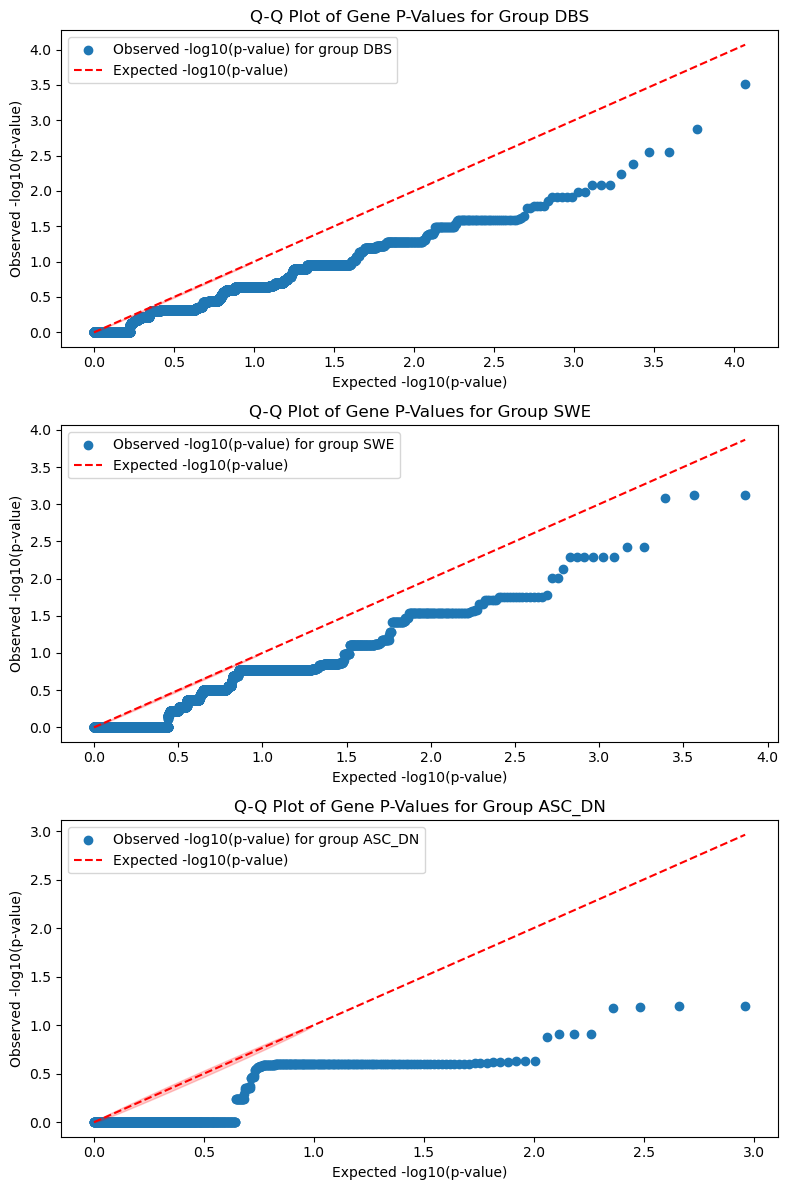

In [15]:
plot_group_QQ(pLoF_genes_df)

## Combine RGC constraint and Alpha Missense pathogenicity into meta regression model

In [16]:
# Subset to useful columns
constraint_predictions_df = constraint_predictions_df[['chr', 'pos', 'prob_0']]

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
max_am_pathogenicity_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for non-pLoF variants
non_pLoF_variants_df = variants_df[~variants_df['consequence'].isin(pLoF_consequence_list)]

# Subset to useful columns
non_pLoF_variants_df = non_pLoF_variants_df[['chr', 'pos', 'gene_id', 'gene_name', 'group', 'ac_case', 'an_case', 'ac_ctrl', 'an_ctrl']]

# Calculate effect size and variance
non_pLoF_variants_df = calculate_effect_size_and_variance(non_pLoF_variants_df)

# Merge constraint predictions, am_pathogenicity predictions, and non_pLoF variants based on chromosome and position
constraint_pathogenicity_non_pLoF_df = pd.merge(non_pLoF_variants_df, pd.merge(constraint_predictions_df, max_am_pathogenicity_df, on=['chr', 'pos'], how='inner'), on=['chr', 'pos'], how='inner')

# Write merged_df to a csv to repeat analysis in R
# constraint_pathogenicity_non_pLoF_df.to_csv(results_path + f"constraint_am_aut_non_pLoF.tsv.gz", index=False, compression='gzip', sep='\t')

constraint_pathogenicity_non_pLoF_df

,chr,pos,gene_id,gene_name,group,ac_case,an_case,ac_ctrl,an_ctrl,effect_size,var_effect_size,prob_0,am_pathogenicity
0,chr1,925969,ENSG00000187634,SAMD11,SWE,0,1490.0,2,7190.0,-0.036067,2.400810,0.019318,0.9695
1,chr1,926009,ENSG00000187634,SAMD11,SWE,0,1490.0,2,7190.0,-0.036067,2.400810,0.000053,0.9415
2,chr1,931058,ENSG00000187634,SAMD11,SWE,0,1490.0,3,7190.0,-0.372678,2.286524,0.002551,0.1961
3,chr1,935812,ENSG00000187634,SAMD11,SWE,0,1490.0,1,7190.0,0.474898,2.667477,0.000063,0.2191
4,chr1,939050,ENSG00000187634,SAMD11,SWE,0,1304.0,1,6180.0,0.456805,2.667595,0.918669,0.1636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567453,chr22,50775839,ENSG00000079974,RABL2B,DBS,0,9622.0,1,10428.0,-1.018270,2.666866,0.000040,0.9849
567454,chr22,50776670,ENSG00000079974,RABL2B,DBS,1,9622.0,0,10428.0,1.179155,2.666866,0.736335,0.9460
567455,chr22,50776696,ENSG00000079974,RABL2B,DBS,1,9622.0,0,10428.0,1.179155,2.666866,0.000075,0.1056
567456,chr22,50776706,ENSG00000079974,RABL2B,DBS,3,9622.0,2,10428.0,0.417031,0.685914,0.000053,0.9205


In [17]:
# Read the data from the file
# constraint_pathogenicity_non_pLoF_df = pd.read_csv(results_path + f'constraint_am_aut_non_pLoF.tsv.gz', sep='\t')

# Initialize lists to store results
meta_model_results = []

# Group data by gene_id, gene_name, and group
grouped_gene_data = constraint_pathogenicity_non_pLoF_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['prob_0'],
            'p_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_const': model.pvalues['const'],
            'p_meta_model': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
meta_model_results_df = pd.DataFrame(meta_model_results)

# Save the DataFrame to a compressed CSV file
# meta_model_results_df.to_csv(results_path + f"aut_meta_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
meta_model_results_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 36169/36551 [02:07<00:01, 284.49gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model
0,ENSG00000000419,DPM1,DBS,0.208902,0.755355,0.944522,0.380179
1,ENSG00000000419,DPM1,SWE,0.338603,0.158376,0.641027,0.302893
2,ENSG00000000457,SCYL3,DBS,0.491048,0.793664,0.833226,0.641112
3,ENSG00000000457,SCYL3,SWE,0.628010,0.636658,0.135628,0.795957
4,ENSG00000000460,C1orf112,DBS,0.466778,0.514206,0.728349,0.645986
...,...,...,...,...,...,...,...
32002,ENSG00000273171,ENSG00000273171,DBS,NaN,NaN,NaN,NaN
32003,ENSG00000273171,ENSG00000273171,SWE,NaN,NaN,NaN,NaN
32004,ENSG00000273173,SNURF,DBS,0.301205,0.261861,0.250731,0.355849
32005,ENSG00000273173,SNURF,SWE,NaN,NaN,NaN,NaN


## Join pLoF and meta regression results into unified model

In [18]:
# pLoF_genes_df = pd.read_csv(results_path + 'aut_pLoF_pvalues.tsv.gz', sep='\t')
# meta_model_results_df = pd.read_csv(results_path + f'aut_meta_model_pvalues.tsv.gz', sep='\t')

pLoF_results_df = pLoF_genes_df[['gene_id', 'gene_name', 'group', 'p_value']].rename({'p_value': 'p_pLoF'}, axis=1)

unified_model_df = pd.merge(meta_model_results_df, pLoF_results_df, on=['gene_id', 'gene_name', 'group'], how='outer')

unified_model_df['p_unified'] = unified_model_df.apply(lambda row: fisher_method(row['p_meta_model'], row['p_pLoF']), axis=1)

unified_model_df.to_csv(results_path + f"aut_unified_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

unified_model_df

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
0,ENSG00000000419,DPM1,DBS,0.208902,0.755355,0.944522,0.380179,1.000000,0.747855
1,ENSG00000000419,DPM1,SWE,0.338603,0.158376,0.641027,0.302893,NaN,0.302893
2,ENSG00000000457,SCYL3,DBS,0.491048,0.793664,0.833226,0.641112,0.688972,0.802631
3,ENSG00000000457,SCYL3,SWE,0.628010,0.636658,0.135628,0.795957,1.000000,0.977602
4,ENSG00000000460,C1orf112,DBS,0.466778,0.514206,0.728349,0.645986,0.500627,0.688473
...,...,...,...,...,...,...,...,...,...
34348,ENSG00000135390,ATP5MC2,DBS,NaN,NaN,NaN,NaN,1.000000,1.000000
34349,ENSG00000164509,IL31RA,SWE,NaN,NaN,NaN,NaN,1.000000,1.000000
34350,ENSG00000067248,DHX29,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000
34351,ENSG00000152669,CCNO,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000


## Analyze results of unified model

In [19]:
unified_model_df = pd.read_csv(results_path + f'aut_unified_model_pvalues.tsv.gz', sep='\t')

filter_mask = (unified_model_df['p_unified'] < 1e-4) | (unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (unified_model_df['gene_name'] == 'CACNA1A')

pd.set_option('display.max_rows', 250)
unified_model_df[filter_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
26724,ENSG00000184156,KCNQ3,ASC_DN,1.867594e-15,2.697764e-15,7.695760e-16,1.879355e-15,NaN,1.879355e-15
4922,ENSG00000103227,LMF1,DBS,2.331820e-15,2.331479e-15,2.323786e-15,2.331479e-15,NaN,2.331479e-15
21585,ENSG00000167656,LY6D,DBS,2.245360e-14,2.249447e-14,2.241177e-14,2.247106e-14,NaN,2.247106e-14
18779,ENSG00000160803,UBQLN4,SWE,1.966299e-15,5.852248e-14,6.856174e-16,4.668620e-14,NaN,4.668620e-14
1417,ENSG00000057608,GDI2,SWE,8.977571e-14,4.306151e-14,3.232104e-14,6.293170e-14,NaN,6.293170e-14
27064,ENSG00000185236,RAB11B,SWE,5.893689e-14,1.175032e-13,3.346340e-16,9.097903e-14,NaN,9.097903e-14
11574,ENSG00000131910,NR0B2,SWE,1.785934e-13,1.632494e-13,1.615007e-13,2.514321e-13,NaN,2.514321e-13
28570,ENSG00000196387,ZNF140,SWE,2.396024e-12,2.189039e-12,8.860867e-14,1.636478e-12,0.313868,1.504818e-11
31382,ENSG00000242372,EIF6,SWE,2.360286e-11,2.410091e-11,4.646681e-12,1.543628e-11,NaN,1.543628e-11
14080,ENSG00000139684,ESD,SWE,1.573609e-10,6.023246e-11,6.430875e-12,1.638230e-11,NaN,1.638230e-11


### Compare against published results

In [25]:
results_pub_df = pd.read_csv(data_path + "Autism_results_2023_12_30_14_36_32.csv", sep=",")
results_pub_df

,Gene,Description,De novo PTV Cases,De novo PTV Controls,De novo MisA Cases,De novo MisA Controls,De novo MisB Cases,De novo MisB Controls,DBS PTV Cases,DBS PTV controls,SWE PTV Cases,SWE PTV Controls,Transmitted,Untransmitted,Q‑Val
0,ENSG00000100888,chromodomain helicase DNA binding protein 8,11,0,3,0,5,0,2,0,0,0,0,1,0.000000e+00
1,ENSG00000136531,sodium voltage-gated channel alpha subunit 2,9,0,2,1,11,0,3,0,0,0,0,0,0.000000e+00
2,ENSG00000197283,synaptic Ras GTPase activating protein 1,10,1,1,0,3,0,4,0,0,0,0,0,0.000000e+00
3,ENSG00000101126,activity dependent neuroprotector homeobox,9,0,0,0,0,0,2,0,1,0,1,0,8.521000e-15
4,ENSG00000114861,forkhead box P1,6,0,0,0,3,0,0,1,0,0,0,0,1.772200e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17339,ENSG00000131848,zinc finger and SCAN domain containing 5A,0,0,0,0,0,0,0,0,0,0,1,1,9.314000e-01
17340,ENSG00000132003,zinc finger SWIM-type containing 4,0,0,0,0,0,0,0,0,0,1,2,0,9.314000e-01
17341,ENSG00000162378,"zyg-11 family member B, cell cycle regulator",0,0,0,0,0,0,0,0,0,0,0,1,9.314000e-01
17342,ENSG00000174442,zwilch kinetochore protein,1,0,0,0,0,0,1,3,0,0,0,1,9.314000e-01


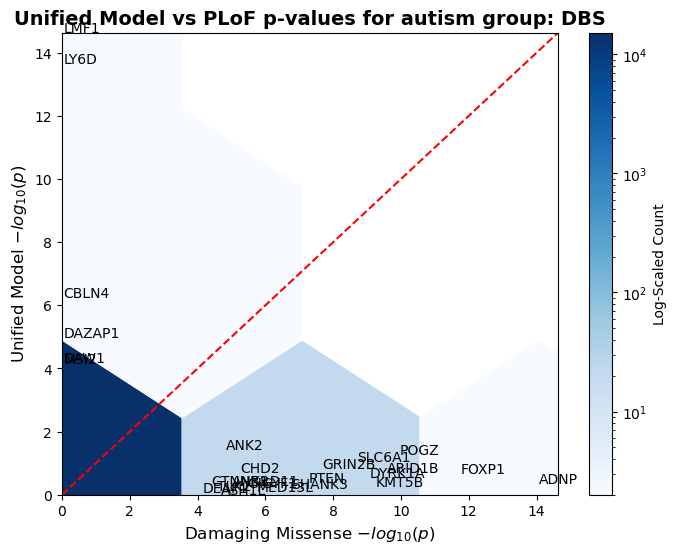

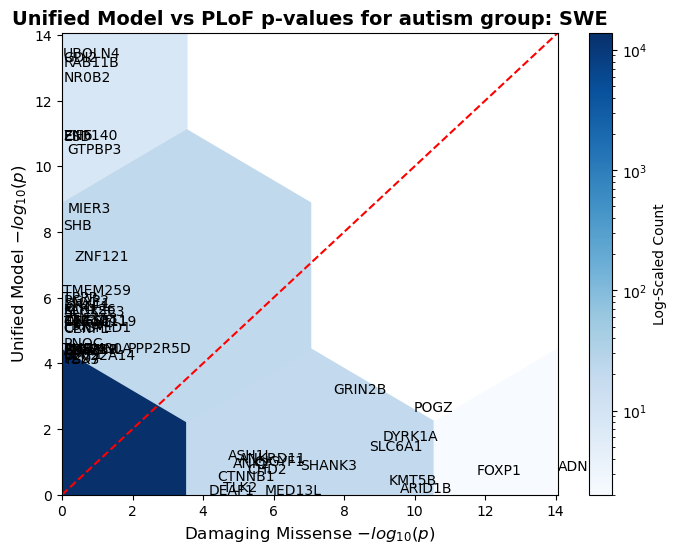

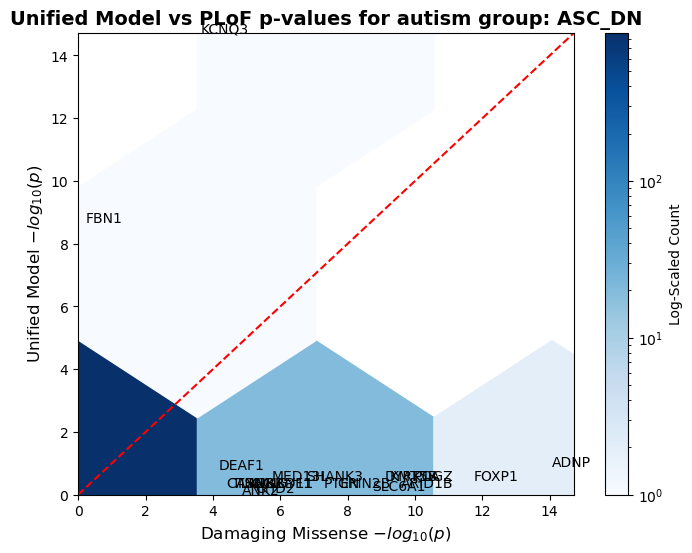

In [29]:
for group in unified_model_df['group'].unique():
    file_pattern = data_path + "Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(unified_model_df[unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model vs PLoF p-values for autism group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")

## Use negative log of constraint prob and pathogenicity prob as input variables

In [26]:
# Read the data from the file
# constraint_pathogenicity_non_pLoF_df = pd.read_csv(results_path + f'constraint_am_aut_non_pLoF.tsv.gz', sep='\t')

# Initialize lists to store results
log_meta_model_results = []

# Group data by gene_id, gene_name, and group
grouped_gene_data = constraint_pathogenicity_non_pLoF_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for gene_key, gene_data in tqdm(grouped_gene_data, desc="Processing genes", unit="gene"):
    gene_id, gene_name, group = gene_key
    
    # Meta-regression model for the gene
    X = sm.add_constant(-np.log(1-gene_data[['prob_0', 'am_pathogenicity']]))
    y = gene_data['effect_size']
    weights = 1 / gene_data['var_effect_size']

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()
        
        # Append results to the list
        log_meta_model_results.append({
            'gene_id': gene_id,
            'gene_name': gene_name,
            'group': group,
            'p_constraint': model.pvalues['prob_0'],
            'p_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_const': model.pvalues['const'],
            'p_meta_model': model.f_pvalue
        })

    except:
        pass

# Create a DataFrame from the results
log_meta_model_results_df = pd.DataFrame(log_meta_model_results)

# Save the DataFrame to a compressed CSV file
# log_meta_model_results_df.to_csv(results_path + f"aut_log_meta_model_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
log_meta_model_results_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 36169/36551 [02:06<00:01, 285.03gene/s]


,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model
0,ENSG00000000419,DPM1,DBS,0.190813,0.918305,0.832847,0.409403
1,ENSG00000000419,DPM1,SWE,0.473935,0.106097,0.872435,0.217585
2,ENSG00000000457,SCYL3,DBS,0.722804,0.518926,0.714623,0.545276
3,ENSG00000000457,SCYL3,SWE,0.675025,0.667328,0.060902,0.830601
4,ENSG00000000460,C1orf112,DBS,0.463766,0.309055,0.750807,0.480237
...,...,...,...,...,...,...,...
31890,ENSG00000273171,ENSG00000273171,DBS,NaN,NaN,NaN,NaN
31891,ENSG00000273171,ENSG00000273171,SWE,NaN,NaN,NaN,NaN
31892,ENSG00000273173,SNURF,DBS,0.369841,0.375288,0.379673,0.476024
31893,ENSG00000273173,SNURF,SWE,NaN,NaN,NaN,NaN


In [27]:
# pLoF_genes_df = pd.read_csv(results_path + 'aut_pLoF_pvalues.tsv.gz', sep='\t')
# log_meta_model_results_df = pd.read_csv(results_path + f'aut_log_meta_model_pvalues.tsv.gz', sep='\t')

pLoF_results_df = pLoF_genes_df[['gene_id', 'gene_name', 'group', 'p_value']].rename({'p_value': 'p_pLoF'}, axis=1)

log_unified_model_df = pd.merge(log_meta_model_results_df, pLoF_results_df, on=['gene_id', 'gene_name', 'group'], how='outer')

log_unified_model_df['p_unified'] = log_unified_model_df.apply(lambda row: fisher_method(row['p_meta_model'], row['p_pLoF']), axis=1)

log_unified_model_df

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
0,ENSG00000000419,DPM1,DBS,0.190813,0.918305,0.832847,0.409403,1.000000,0.775022
1,ENSG00000000419,DPM1,SWE,0.473935,0.106097,0.872435,0.217585,NaN,0.217585
2,ENSG00000000457,SCYL3,DBS,0.722804,0.518926,0.714623,0.545276,0.688972,0.743477
3,ENSG00000000457,SCYL3,SWE,0.675025,0.667328,0.060902,0.830601,1.000000,0.984765
4,ENSG00000000460,C1orf112,DBS,0.463766,0.309055,0.750807,0.480237,0.500627,0.583106
...,...,...,...,...,...,...,...,...,...
34279,ENSG00000135390,ATP5MC2,DBS,NaN,NaN,NaN,NaN,1.000000,1.000000
34280,ENSG00000164509,IL31RA,SWE,NaN,NaN,NaN,NaN,1.000000,1.000000
34281,ENSG00000067248,DHX29,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000
34282,ENSG00000152669,CCNO,ASC_DN,NaN,NaN,NaN,NaN,1.000000,1.000000


In [28]:
filter_mask = (log_unified_model_df['p_unified'] < 1e-4) | (log_unified_model_df['p_constraint'] < 1e-4)
gene_name_mask = (log_unified_model_df['gene_name'] == 'CACNA1A')

pd.set_option('display.max_rows', 250)
log_unified_model_df[filter_mask].sort_values('p_unified')

,gene_id,gene_name,group,p_constraint,p_pathogenicity,p_const,p_meta_model,p_pLoF,p_unified
30567,ENSG00000213937,CLDN9,SWE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
4899,ENSG00000103227,LMF1,DBS,2.811750e-15,2.832942e-15,2.811694e-15,2.832942e-15,NaN,2.832942e-15
21498,ENSG00000167656,LY6D,DBS,4.059328e-15,4.120267e-15,4.055301e-15,4.119901e-15,NaN,4.119901e-15
26624,ENSG00000184156,KCNQ3,ASC_DN,1.462198e-14,2.194617e-14,1.443773e-14,2.099081e-14,NaN,2.099081e-14
18702,ENSG00000160803,UBQLN4,SWE,1.289679e-15,8.322053e-14,8.667957e-16,6.783347e-14,NaN,6.783347e-14
26964,ENSG00000185236,RAB11B,SWE,2.816596e-13,5.461086e-13,1.321781e-15,4.228323e-13,NaN,4.228323e-13
1410,ENSG00000057608,GDI2,SWE,4.741478e-13,3.821383e-13,2.830804e-13,5.584695e-13,NaN,5.584695e-13
11525,ENSG00000131910,NR0B2,SWE,5.877623e-13,5.401973e-13,5.340784e-13,8.319899e-13,NaN,8.319899e-13
31271,ENSG00000242372,EIF6,SWE,3.789251e-12,4.620857e-12,6.166489e-14,2.959546e-12,NaN,2.959546e-12
11085,ENSG00000130299,GTPBP3,SWE,4.746080e-13,3.034983e-01,2.431220e-10,1.464752e-12,0.171699,7.547740e-12


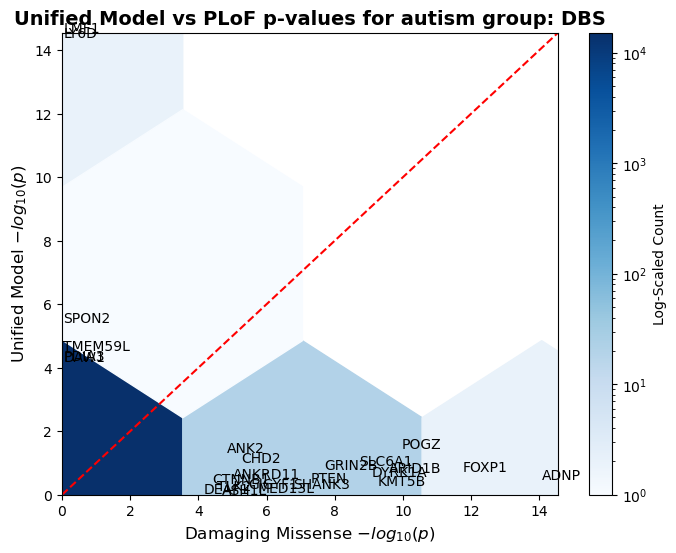

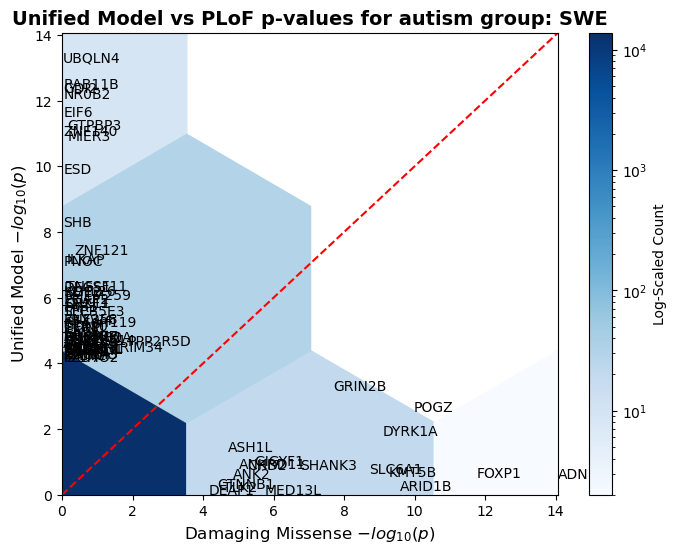

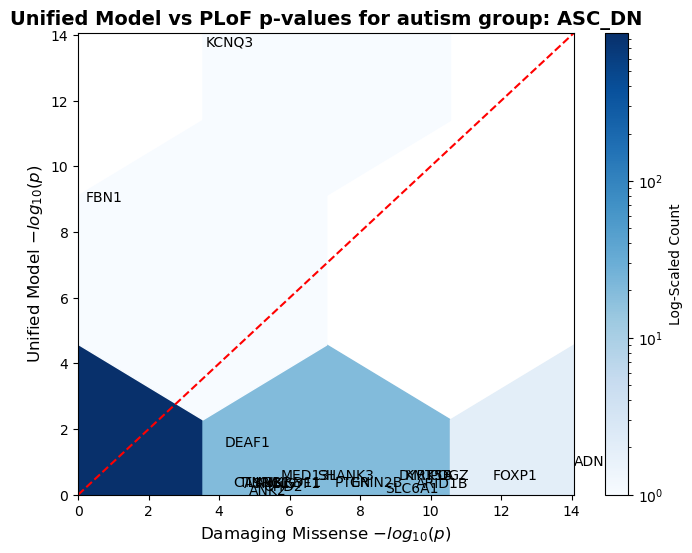

In [30]:
for group in log_unified_model_df['group'].unique():
    file_pattern = data_path + "Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(log_unified_model_df[log_unified_model_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_unified'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value

        # Create a hexbin (smoothscatter) plot with log scale
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues', norm=LogNorm())

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points with larger fontsize
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=10)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title (bolded)
        plt.xlabel(r'Damaging Missense $-log_{10}(p)$', fontsize=12)
        plt.ylabel(r'Unified Model $-log_{10}(p)$', fontsize=12)
        plt.title(f'Unified Model vs PLoF p-values for autism group: {group}', fontsize=14, fontweight="bold")

        # Show color bar
        plt.colorbar(label='Log-Scaled Count')

        plt.show()

    else:
        print(f"No files found for group {group}")